# Using tf.keras

This Colab is about how to use Keras to define and train simple models on the data generated in the last Colab [1_data.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/1_data.ipynb)

In [1]:
# In Jupyter, you would need to install TF 2.0 via !pip.
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import json, os

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

version=2.1.0, CUDA=True, GPU=True, TPU=False


> **Attention:** Please avoid using the TPU runtime (`TPU=True`) for now. The notebook contains an optional part on TPU usage at the end if you're interested. You can change the runtime via: "Runtime > Change runtime type > Hardware Accelerator" in Colab.

## Data from Protobufs

In [0]:
# Load data from Drive (Colab only).
data_path = '/content/gdrive/My Drive/amld_data/zoo_img'

# Or, you can load data from different sources, such as:
# From your local machine:
# data_path = './amld_data'

# Or use a prepared dataset from Cloud (Colab only).
# - 50k training examples, including pickled DataFrame.
# data_path = 'gs://amld-datasets/zoo_img_small'
# - 1M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/zoo_img'
# - 4.1M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/animals_img'
# - 29M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/all_img'

# Store models on Drive (Colab only).
models_path = '/content/gdrive/My Drive/amld_data/models'

# Or, store models to local machine.
# models_path = './amld_models'

In [4]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()
  !gsutil ls -lh "$data_path"
else:
  !sleep 1  # wait a bit for the mount to become ready
  !ls -lh "$data_path"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 2.9G
-rw------- 1 root root   46 Jan 25 22:58 counts.json
-rw------- 1 root root 2.5G Jan 25 23:00 dataframe.pkl
-rw------- 1 root root  11M Jan 25 22:58 eval-00000-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00001-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00002-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00003-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00004-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00005-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00006-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00007-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00008-of-00010
-rw------- 1 root root  11M Jan 25 22:58 eval-00009-of-00010
-rw------- 1 root root   89 Jan 25 22:58 labels.txt
-rw------- 1 root root 5.1M Jan 25 22:58 test-00000-of-00010
-rw------- 1 root root 5.1M

In [5]:
labels = [label.strip() for label 
          in tf.io.gfile.GFile('{}/labels.txt'.format(data_path))]
print('All labels in the dataset:', ' '.join(labels))

counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(data_path)))
print('Splits sizes:', counts)

All labels in the dataset: camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros
Splits sizes: {'eval': 20000, 'test': 10000, 'train': 50000}


In [6]:
# This dictionary specifies what "features" we want to extract from the
# tf.train.Example protos (i.e. what they look like on disk). We only
# need the image data "img_64" and the "label". Both features are tensors
# with a fixed length.
# You need to specify the correct "shape" and "dtype" parameters for
# these features.
feature_spec = {
    # Single label per example => shape=[1] (we could also use shape=() and
    # then do a transformation in the input_fn).
    'label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64),
    # The bytes_list data is parsed into tf.string.
    'img_64': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
  # Convert string to tf.train.Example and then extract features/label.
  features = tf.io.parse_single_example(serialized_example, feature_spec)

  label = features['label']
  label = tf.one_hot(tf.squeeze(label), len(labels))

  features['img_64'] = tf.cast(features['img_64'], tf.float32) / 255.
  return features['img_64'], label

batch_size = 100
steps_per_epoch = counts['train'] // batch_size
eval_steps_per_epoch = counts['eval'] // batch_size

# Create datasets from TFRecord files.
train_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/train-*'.format(data_path)))
train_ds = train_ds.map(parse_example)
train_ds = train_ds.batch(batch_size).repeat()

eval_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/eval-*'.format(data_path)))
eval_ds = eval_ds.map(parse_example)
eval_ds = eval_ds.batch(batch_size)

# Read a single batch of examples from the training set and display shapes.
for img_feature, label in train_ds:
  break
print('img_feature.shape (batch_size, image_height, image_width) =', 
      img_feature.shape)
print('label.shape (batch_size, number_of_labels) =', label.shape)

img_feature.shape (batch_size, image_height, image_width) = (100, 64, 64)
label.shape (batch_size, number_of_labels) = (100, 11)


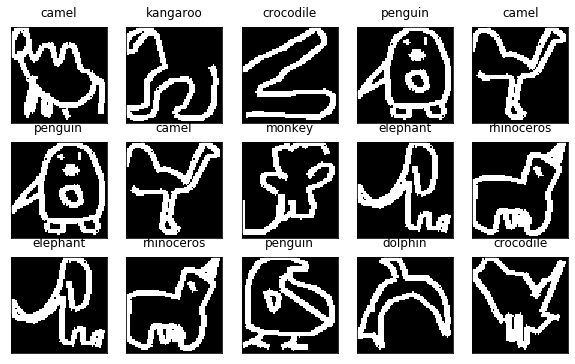

In [7]:
# Visualize some examples from the training set.
from matplotlib import pyplot as plt

def show_img(img_64, title='', ax=None):
  """Displays an image.
  
  Args:
    img_64: Array (or Tensor) with monochrome image data.
    title: Optional title.
    ax: Optional Matplotlib axes to show the image in.
  """
  (ax if ax else plt).matshow(img_64.reshape((64, -1)), cmap='gray')
  if isinstance(img_64, tf.Tensor):
    img_64 = img_64.numpy()
  ax = ax if ax else plt.gca()
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
    
rows, cols = 3, 5
for img_feature, label in train_ds:
  break
_, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for i in range(rows):
  for j in range(cols):
    show_img(img_feature[i*rows+j].numpy(), 
             title=labels[label[i*rows+j].numpy().argmax()], ax=axs[i][j])

## Linear model

In [8]:
# Sample linear model.
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
linear_model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

# "adam, categorical_crossentropy, accuracy" and other string constants can be
# found at https://keras.io.
linear_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [9]:
linear_model.fit(train_ds,
                 validation_data=eval_ds,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=eval_steps_per_epoch,
                 epochs=1,
                 verbose=True)

Train for 500 steps, validate for 200 steps
500/500 [==============================] - 26s 53ms/step - loss: 1.3906 - accuracy: 0.5448 - categorical_accuracy: 0.5448 - val_loss: 1.3743 - val_accuracy: 0.5543 - val_categorical_accuracy: 0.5543


## Convolutional model

In [10]:
# Let's define a convolutional model:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(10, 10), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(10, 10), 
                           padding='same', 
                           activation='relu'),                      
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(5, 5), 
                           padding='same', 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(labels), activation='softmax'),
])

# YOUR ACTION REQUIRED:
# Compile + print summary of the model (analogous to the linear model above).
#--snip
conv_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        3232      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        102432    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [11]:
# YOUR ACTION REQUIRED:
# Train the model (analogous to linear model above).
# Note: You might want to reduce the number of steps if if it takes too long.
# Pro tip: Change the runtime type ("Runtime" menu) to GPU! After the change you
# will need to rerun the cells above because the Python kernel's state is reset.
#--snip
conv_model.fit(train_ds,
               validation_data=eval_ds,
               steps_per_epoch=steps_per_epoch,
               validation_steps=eval_steps_per_epoch,
               epochs=3,
               verbose=True)

Train for 500 steps, validate for 200 steps
Epoch 1/3
500/500 [==============================] - 41s 81ms/step - loss: 0.8283 - accuracy: 0.7213 - val_loss: 0.5068 - val_accuracy: 0.8295
Epoch 2/3
500/500 [==============================] - 31s 62ms/step - loss: 0.4505 - accuracy: 0.8500 - val_loss: 0.4331 - val_accuracy: 0.8572
Epoch 3/3
500/500 [==============================] - 31s 62ms/step - loss: 0.3584 - accuracy: 0.8794 - val_loss: 0.4421 - val_accuracy: 0.8591


## Store model

In [0]:
tf.io.gfile.makedirs(models_path)

In [0]:
# Save model as Keras model.
keras_path = os.path.join(models_path, 'linear.h5')
linear_model.save(keras_path)

In [14]:
# Keras model is a single file.
!ls -hl "$keras_path"

-rw------- 1 root root 548K Feb 26 22:35 '/content/gdrive/My Drive/amld_data/models/linear.h5'


In [15]:
# Load Keras model.
loaded_keras_model = tf.keras.models.load_model(keras_path)
loaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Save model as Tensorflow Saved Model.
saved_model_path = os.path.join(models_path, 'saved_model/linear')
linear_model.save(saved_model_path, save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/amld_data/models/saved_model/linear/assets


In [17]:
# Inspect saved model directory structure.
!find "$saved_model_path"

/content/gdrive/My Drive/amld_data/models/saved_model/linear
/content/gdrive/My Drive/amld_data/models/saved_model/linear/variables
/content/gdrive/My Drive/amld_data/models/saved_model/linear/variables/variables.data-00000-of-00001
/content/gdrive/My Drive/amld_data/models/saved_model/linear/variables/variables.index
/content/gdrive/My Drive/amld_data/models/saved_model/linear/variables/variables.data-00001-of-00002
/content/gdrive/My Drive/amld_data/models/saved_model/linear/variables/variables.data-00000-of-00002
/content/gdrive/My Drive/amld_data/models/saved_model/linear/assets
/content/gdrive/My Drive/amld_data/models/saved_model/linear/saved_model.pb


In [18]:
saved_model = tf.keras.models.load_model(saved_model_path)
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [19]:
# YOUR ACTION REQUIRED:
# Store the convolutional model and any additional models that you trained
# in the previous sections in Keras format so we can use them in later
# notebooks for prediction.
#--snip
conv_model.save(os.path.join(models_path, 'conv.h5'))
!ls -lh "$models_path"

total 5.5M
drwx------ 2 root root 4.0K Jan 26  2019 competition
-rw------- 1 root root 4.9M Feb 26 22:36 conv.h5
-rw------- 1 root root 548K Feb 26 22:35 linear.h5
drwx------ 3 root root 4.0K Jan 23  2019 saved_model


# ----- Optional part -----

## Learn from errors

Looking at classification mistakes is a great way to better understand how a model is performing. This section walks you through the necessary steps to load some examples from the dataset, make predictions, and plot the mistakes.

In [0]:
import collections
Mistake = collections.namedtuple('Mistake', 'label pred img_64')
mistakes = []
eval_ds_iter = iter(eval_ds)

In [21]:
for img_64_batch, label_onehot_batch in eval_ds_iter:
  break
img_64_batch.shape, label_onehot_batch.shape

(TensorShape([100, 64, 64]), TensorShape([100, 11]))

In [0]:
# YOUR ACTION REQUIRED:
# Use model.predict() to get a batch of predictions.
preds = linear_model.predict(img_64_batch)  #preds =

In [23]:
# Iterate through the batch:
for label_onehot, pred, img_64 in zip(label_onehot_batch, preds, img_64_batch):
  # YOUR ACTION REQUIRED:
  # Both `label_onehot` and pred are vectors with length=len(labels), with every
  # element corresponding to a probability of the corresponding class in
  # `labels`. Get the value with the highest value to get the index within
  # `labels`.
  label_i = label_onehot.numpy().argmax()  #label_i = 
  pred_i = pred.argmax()  #pred_i =
  if label_i != pred_i:
    mistakes.append(Mistake(label_i, pred_i, img_64.numpy()))

# You can run this and above 2 cells multiple times to get more mistakes. 
len(mistakes)

48

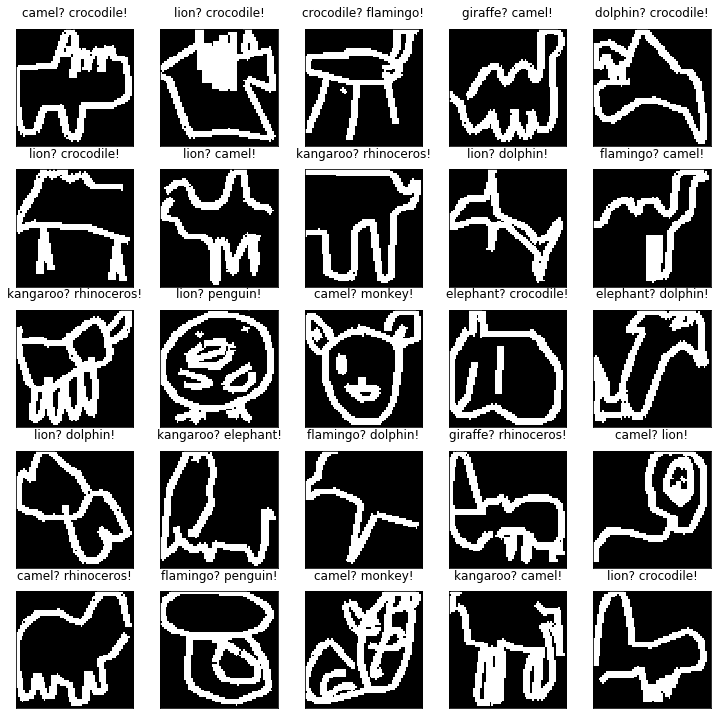

In [24]:
# Let's examine the cases when our model gets it wrong. Would you recognize
# these images correctly?

# YOUR ACTION REQUIRED:
# Run above cell but using a different model to get a different set of
# classification mistakes. Then copy over this cell to plot the mistakes for
# comparison purposes. Can you spot a pattern?
rows, cols = 5, 5
plt.figure(figsize=(cols*2.5, rows*2.5))
for i, mistake in enumerate(mistakes[:rows*cols]):
  ax = plt.subplot(rows, cols, i + 1)
  title = '{}? {}!'.format(labels[mistake.pred], labels[mistake.label])
  show_img(mistake.img_64, title, ax)

## Data from DataFrame

For comparison, this section shows how you would load data from a `pandas.DataFrame` and then use Keras for training. Note that this approach does not scale well and can only be used for quite small datasets.

In [25]:
# Note: used memory BEFORE loading the DataFrame.
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        2.3G        5.4G         44M        5.0G         10G
Swap:            0B          0B          0B


In [26]:
# Loading all the data in memory takes a while (~40s).
import pickle
df = pickle.load(tf.io.gfile.GFile('%s/dataframe.pkl' % data_path, mode='rb'))
print(len(df))
print(df.columns)

80000
Index(['key_id', 'recognized', 'img_64', 'countrycode', 'split', 'label',
       'word', 'timestamp'],
      dtype='object')


In [27]:
df_train = df[df.split == b'train']
len(df_train)

50000

In [28]:
# Note: used memory AFTER loading the DataFrame.
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        5.1G        152M         44M        7.4G        7.5G
Swap:            0B          0B          0B


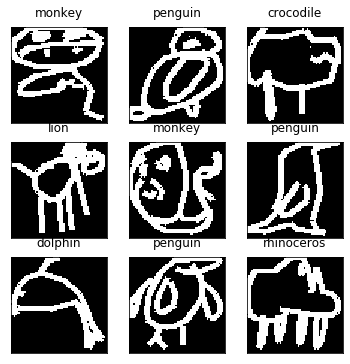

In [29]:
# Show some images from the dataset.

from matplotlib import pyplot as plt

def show_img(img_64, title='', ax=None):
  (ax if ax else plt).matshow(img_64.reshape((64, -1)), cmap='gray')
  ax = ax if ax else plt.gca()
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)

rows, cols = 3, 3
_, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for i in range(rows):
  for j in range(cols):
    d = df.sample(1).iloc[0]
    show_img(d.img_64, title=labels[d.label], ax=axs[i][j])

In [0]:
df_x = tf.convert_to_tensor(df_train.img_64, dtype=tf.float32)
df_y = tf.one_hot(df_train.label, depth=len(labels), dtype=tf.float32)

In [31]:
# Note: used memory AFTER defining the Tenors based on the DataFrame.
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        5.9G        150M         44M        6.7G        6.7G
Swap:            0B          0B          0B


In [32]:
# Checkout the shape of these rather large tensors.
df_x.shape, df_x.dtype, df_y.shape, df_y.dtype

(TensorShape([50000, 4096]), tf.float32, TensorShape([50000, 11]), tf.float32)

In [33]:
# Copied code from section "Linear model" above.
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Flatten(input_shape=(64 * 64,)))
linear_model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

# "adam, categorical_crossentropy, accuracy" and other string constants can be
# found at https://keras.io.
linear_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])
linear_model.summary()

# How much of a speedup do you see because the data is already in memory?
# How would this compare to the convolutional model?
linear_model.fit(df_x, df_y, epochs=1, batch_size=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples
50000/50000 [==============================] - 2s 36us/sample - loss: 98.7476 - accuracy: 0.4335 - categorical_accuracy: 0.4335


## TPU Support

For using TF with a TPU we'll need to make some adjustments. Generally, please note that several TF TPU features are experimental and might not work as smooth as it does with a CPU or GPU.

> **Attention:** Please make sure to switch the runtime to TPU for this part. You can do so via: "Runtime > Change runtime type > Hardware Accelerator" in Colab. As this might create a new environment this section can be executed isolated from anything above.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import json, os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# Disable duplicate logging output in TF.
logger = tf.get_logger()
logger.propagate = False

# This will fail if no TPU is connected...
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# Set up distribution strategy.
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu);
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Tested with TensorFlow 2.1.0
print('\n\nTF version={} TPUs={} accelerators={}'.format(
    tf.__version__, tpu.cluster_spec().as_dict()['worker'],
    strategy.num_replicas_in_sync))

INFO:tensorflow:Initializing the TPU system: 10.35.107.2:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflo

> **Attention:** TPUs require all files (input and models) to be stored in cloud storage buckets (`gs://bucket-name/...`). If you plan to use TPUs please choose the `data_path` below accordingly. Otherwise, you might run into `File system scheme '[local]' not implemented` errors.

In [0]:
from google.colab import auth
auth.authenticate_user()

# Browse datasets:
# https://console.cloud.google.com/storage/browser/amld-datasets

# - 50k training examples, including pickled DataFrame.
data_path = 'gs://amld-datasets/zoo_img_small'
# - 1M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/zoo_img'
# - 4.1M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/animals_img'
# - 29M training examples, without pickled DataFrame.
# data_path = 'gs://amld-datasets/all_img'

In [4]:
#@markdown **Copied and adjusted data definition code from above**
#@markdown
#@markdown &nbsp;&nbsp; Note: You can double-click this cell to see its code.
#@markdown
#@markdown The changes have been highlighted with `!` in the contained code
#@markdown (things like the `batch_size` and added `drop_remainder=True`).
#@markdown
#@markdown Feel free to just **click "execute"** and ignore the details for now.

labels = [label.strip() for label 
          in tf.io.gfile.GFile('{}/labels.txt'.format(data_path))]
print('All labels in the dataset:', ' '.join(labels))

counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(data_path)))
print('Splits sizes:', counts)

# This dictionary specifies what "features" we want to extract from the
# tf.train.Example protos (i.e. what they look like on disk). We only
# need the image data "img_64" and the "label". Both features are tensors
# with a fixed length.
# You need to specify the correct "shape" and "dtype" parameters for
# these features.
feature_spec = {
    # Single label per example => shape=[1] (we could also use shape=() and
    # then do a transformation in the input_fn).
    'label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64),
    # The bytes_list data is parsed into tf.string.
    'img_64': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
  # Convert string to tf.train.Example and then extract features/label.
  features = tf.io.parse_single_example(serialized_example, feature_spec)

  # Important step: remove "label" from features!
  # Otherwise our classifier would simply learn to predict
  # label=features['label'].
  label = features['label']
  label = tf.one_hot(tf.squeeze(label), len(labels))

  features['img_64'] = tf.cast(features['img_64'], tf.float32)
  return features['img_64'], label

# Adjust the batch size to the given hardware (#accelerators).
batch_size = 64 * strategy.num_replicas_in_sync
#            !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
steps_per_epoch = counts['train'] // batch_size
eval_steps_per_epoch = counts['eval'] // batch_size

# Create datasets from TFRecord files.
train_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/train-*'.format(data_path)))
train_ds = train_ds.map(parse_example)
train_ds = train_ds.batch(batch_size, drop_remainder=True).repeat()
#                                     !!!!!!!!!!!!!!!!!!!

eval_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/eval-*'.format(data_path)))
eval_ds = eval_ds.map(parse_example)
eval_ds = eval_ds.batch(batch_size, drop_remainder=True)
#                                   !!!!!!!!!!!!!!!!!!!
# Read a single example and display shapes.
for img_feature, label in train_ds:
  break
print('img_feature.shape (batch_size, image_height, image_width) =', 
      img_feature.shape)
print('label.shape (batch_size, number_of_labels) =', label.shape)

All labels in the dataset: camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros
Splits sizes: {'eval': 10000, 'test': 20000, 'train': 50000}
img_feature.shape (batch_size, image_height, image_width) = (512, 64, 64)
label.shape (batch_size, number_of_labels) = (512, 11)


In [5]:
# Model definition code needs to be wrapped in scope.
with strategy.scope():
  linear_model = tf.keras.Sequential()
  linear_model.add(tf.keras.layers.Flatten(input_shape=(64,  64,)))
  linear_model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

linear_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [6]:
linear_model.fit(train_ds,
                 validation_data=eval_ds,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=eval_steps_per_epoch,
                 epochs=1,
                 verbose=True)

Train for 97 steps, validate for 19 steps
97/97 [==============================] - 30s 304ms/step - loss: 96.6914 - accuracy: 0.4227 - categorical_accuracy: 0.4227 - val_loss: 66.2868 - val_accuracy: 0.4507 - val_categorical_accuracy: 0.4507


In [7]:
# Model definition code needs to be wrapped in scope.
with strategy.scope():
  conv_model = tf.keras.Sequential([
      tf.keras.layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
      tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=(10, 10), 
                            padding='same', 
                            activation='relu'),
      tf.keras.layers.ZeroPadding2D((1,1)),
      tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=(10, 10), 
                            padding='same', 
                            activation='relu'),                      
      tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),
      tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=(5, 5), 
                            padding='same', 
                            activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(len(labels), activation='softmax'),
  ])

conv_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        3232      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 32)        102432    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)         

In [8]:
conv_model.fit(train_ds,
               validation_data=eval_ds,
               steps_per_epoch=steps_per_epoch,
               validation_steps=eval_steps_per_epoch,
               epochs=3,
               verbose=True)
conv_model.evaluate(eval_ds, steps=eval_steps_per_epoch)

Train for 97 steps, validate for 19 steps
Epoch 1/3
97/97 [==============================] - 68s 701ms/step - loss: 3.0446 - accuracy: 0.3531 - val_loss: 1.0366 - val_accuracy: 0.6579
Epoch 2/3
97/97 [==============================] - 9s 93ms/step - loss: 0.9978 - accuracy: 0.6672 - val_loss: 0.7425 - val_accuracy: 0.7401
Epoch 3/3
19/19 [==============================] - 1s 75ms/step - loss: 0.6351 - accuracy: 0.7697


[0.6350698502440202, 0.7697368]